In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
from math import sqrt
import warnings

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder, MinMaxScaler


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['savefig.dpi'] = 600
plt.rcParams["savefig.format"] = 'tiff'
warnings.filterwarnings("ignore")

In [2]:
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=2)


In [3]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
  if epoch < 160:
    return lr
  else:
    return lr * np.exp(-0.1)

callback = keras.callbacks.LearningRateScheduler(scheduler)



# Neural Network
def Neural_network():
    init = keras.initializers.random_normal()
    model=Sequential()
    model.add(layers.Dense(64,activation='relu',kernel_initializer=init, input_dim=scaled_DF.shape[1]))
    model.add(layers.Dropout(0.1))
    

    model.add(layers.Dense(128,activation='relu',kernel_initializer=init))
    model.add(layers.Dropout(0.1))

    
    model.add(layers.Dense(128,activation='relu',kernel_initializer=init))
    model.add(layers.Dropout(0.1))

    
    model.add(layers.Dense(1,kernel_initializer=init,activation = 'linear'))
 
    
    optimize=tf.keras.optimizers.Adam()
    
    model.compile(optimizer=optimize,
                    loss='mse',
                    )
    return model

# To calclulate  Correlation and remove highly  correlated columns
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [4]:
# Funtion to train the model
def training_model(X_train,Y_train,model):
    history=model.fit(X_train,Y_train,epochs=200,batch_size=64,verbose=0,callbacks=[callback])
    return history

In [5]:
# To print losses
def plots():
    f, ax = plt.subplots(1,1)
    actual_test=np.array(scaler.inverse_transform(testY).reshape(-1,1))
    predicted_test=np.array(scaler.inverse_transform(model.predict(testX).reshape(-1,1)))

    #actual=testY
    #predicted= model.predict(testX)

    actual=np.array(scaler.inverse_transform(np.array(trainY).reshape(-1,1)))
    predicted=np.array(scaler.inverse_transform(model.predict(np.array(trainX)).reshape(-1,1)))

    sns.regplot(actual,predicted, color='midnightblue', scatter_kws={'alpha':0.5}, label='Train')
    plt.scatter(actual_test,predicted_test, color='crimson', alpha=0.5, label='Test') #linewidths=0.5, edgecolors='orange')
    
    
    print("Mean absolute error (MAE):      %f" % mean_absolute_error(actual_test,predicted_test))
    print("Mean squared error (MSE):       %f" % mean_squared_error(actual_test,predicted_test))
    print("Root mean squared error (RMSE): %f" % sqrt(mean_squared_error(actual_test,predicted_test)))
    print("R square (R^2):                 %f" % r2_score(actual_test,predicted_test))
    
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    #plt.suptitle("Actual Vs Predicted")
    anchored_text = AnchoredText("R\u00b2 Score_train  "+str(round(r2_score(actual,predicted),3))+'\n'"R\u00b2 Score_test  "+str(round(r2_score(actual_test,predicted_test),3)), loc=2,prop=dict(size=15))
    ax.add_artist(anchored_text)
    plt.savefig(str(model)[1:6], bbox_inches='tight')
    plt.legend(loc = 9, prop={'size': 15}) #labels=["Test","Train"], 
    plt.tight_layout()
    plt.show()

In [6]:
def defining_model(x):
    if x == 'mlr':
      model = LinearRegression()
    elif x=='adboost':
      model = AdaBoostRegressor()
    elif x=='xtratree':
      model = ExtraTreesRegressor()
    elif x=='bagging':
      model = BaggingRegressor()
    elif x=='pls':
      model = PLSRegression()
    elif x=='rndmfrst':
      model = RandomForestRegressor()
    elif x=='knn':
      model = KNeighborsRegressor()
    elif x=='svr':
      model = SVR()
    else:
      print("wrong selection")
    return model



In [7]:
# Getting data from CSV file
Train = pd.read_excel('train.xlsx')
Test = pd.read_excel('test.xlsx')
display(Train)
display(Test)

,Name of the Molecule,Solvent type,Smiles,N-Het,E(Energy),E(HOMO),E(LUMO),ꭓ(Electronegativity),µ(Chemical Potential),ɳ(Hardness),Ѡ(Electophilicity Index),d(Dipole Moment),H(Enthalpy),G(Gibbs Free Energy),Et(30)
0,"1,2-dibromobenzene",Arenes,BrC1=C(Br)C=CC=C1,2,-5374.517475,-0.25487,-0.03984,0.147355,-0.147355,0.21503,0.002335,2.449100,-3.372453e+06,-3.372479e+06,37.6
1,pentachloroethane,Halo-alkanes/alkenes/alkynes,ClC(Cl)(Cl)C(Cl)Cl,5,-2377.770950,-0.31742,-0.06490,0.191160,-0.191160,0.25252,0.004614,0.984451,-1.492028e+06,-1.492055e+06,36.7
2,2-cyanoethanol,Alcohols/Phenols,OCCC#N,2,-247.296906,-0.30510,-0.02688,0.165990,-0.165990,0.27822,0.003833,4.977471,-1.551250e+05,-1.551473e+05,59.3
3,pyrrole,Heteroarenes,C1=CC=CN1,1,-210.188315,-0.21610,-0.01287,0.114485,-0.114485,0.20323,0.001332,1.912000,-1.318383e+05,-1.318579e+05,51.0
4,"1,2-dichlorohexafluorocyclobutane",Halo-alkanes/alkenes/alkynes,ClC1(F)C(F)(F)C(F)(F)C1(Cl)F,8,-1671.838707,-0.34004,-0.07576,0.207900,-0.207900,0.26428,0.005711,1.135401,-1.049044e+06,-1.049075e+06,33.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,"2,5-dibromo-1-methylbenzene",Arenes,BrC1=CC=C(Br)C=C1C,2,-5413.847711,-0.24730,-0.03920,0.143250,-0.143250,0.20810,0.002135,0.621862,-3.397114e+06,-3.397141e+06,34.7
248,triethylamine,Nitrogen containing compounds,CCN(CC)CC,1,-292.444389,-0.20784,-0.00873,0.108285,-0.108285,0.19911,0.001167,0.610712,-1.833734e+05,-1.834014e+05,32.1
249,4-heptanone,Ketones,O=C(CCC)CCC,1,-350.441782,-0.25002,-0.02776,0.138890,-0.138890,0.22226,0.002144,2.996110,-2.197708e+05,-2.198012e+05,38.9
250,hexamethylphosphuric acid triamide,Phosphorous compounds,O=P(N(C)C)(N(C)C)N(C)C,5,-820.381408,-0.22090,-0.01689,0.118895,-0.118895,0.20401,0.001442,3.887586,-5.146193e+05,-5.146559e+05,40.9


,Name of the Molecule,Solvent type,Smiles,N-Het,E(Energy),E(HOMO),E(LUMO),ꭓ(Electronegativity),µ(Chemical Potential),ɳ(Hardness),Ѡ(Electophilicity Index),d(Dipole Moment),H(Enthalpy),G(Gibbs Free Energy),Et(30)
0,"2,2,2-trichloroethanol",Alcohols/Phenols,ClC(Cl)(Cl)CO,4,-1533.818197,-0.30902,-0.05119,0.180105,-0.180105,0.25783,0.004182,3.140522,-9.624339e+05,-9.624587e+05,54.1
1,tris(n-butyl)amine,Nitrogen containing compounds,CCCCN(CCCC)CCCC,1,-528.343369,-0.20399,-0.00926,0.106625,-0.106625,0.19473,0.001107,0.610354,-3.312880e+05,-3.313294e+05,32.1
2,triethyl phosphate,Phosphorous compounds,O=P(OCC)(OCC)OCC,5,-880.049965,-0.29057,-0.01369,0.152130,-0.152130,0.27688,0.003204,3.950039,-5.520842e+05,-5.521218e+05,41.2
3,Tetramethylsilane,Alkanes and alkenes,C[Si](C)(C)C,1,-449.218697,-0.29683,-0.01465,0.155740,-0.155740,0.28218,0.003422,0.000000,-2.817858e+05,-2.818111e+05,31.1
4,methyl octanoate,Esters,COC(CCCCCCC)=O,2,-504.314533,-0.28199,-0.01035,0.146170,-0.146170,0.27164,0.002902,1.632103,-3.162846e+05,-3.163213e+05,35.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,1-bromopropane,Halo-alkanes/alkenes/alkynes,CCCBr,1,-2690.281117,-0.27695,-0.02366,0.150305,-0.150305,0.25329,0.002861,2.398647,-1.688088e+06,-1.688111e+06,36.9
165,2-nitropropane,Nitrogen containing compounds,CC(C)[N+]([O-])=O,3,-323.671490,-0.30518,-0.08235,0.193765,-0.193765,0.22283,0.004183,4.115131,-2.030321e+05,-2.030565e+05,42.0
166,veratrole,"Ethers,thioethers and acetals",COC1=C(OC)C=CC=C1,2,-461.318768,-0.22260,-0.01187,0.117235,-0.117235,0.21073,0.001448,2.285830,-2.893673e+05,-2.893958e+05,38.4
167,tetra-n-propylammonium 2-(cyclohexylamino)etha...,Organic salts,CCC[N+](CCC)(CCC)CCC.O=S(CCNC1CCCCC1)([O-])=O,6,-1522.030882,-0.20554,-0.03594,0.120740,-0.120740,0.16960,0.001236,12.750378,-9.546518e+05,-9.547157e+05,50.9


In [8]:
# Combine Train and test for feature engineering
DF = pd.concat([Train,Test],ignore_index=True)
DF_data = DF.copy()
DF

,Name of the Molecule,Solvent type,Smiles,N-Het,E(Energy),E(HOMO),E(LUMO),ꭓ(Electronegativity),µ(Chemical Potential),ɳ(Hardness),Ѡ(Electophilicity Index),d(Dipole Moment),H(Enthalpy),G(Gibbs Free Energy),Et(30)
0,"1,2-dibromobenzene",Arenes,BrC1=C(Br)C=CC=C1,2,-5374.517475,-0.25487,-0.03984,0.147355,-0.147355,0.21503,0.002335,2.449100,-3.372453e+06,-3.372479e+06,37.6
1,pentachloroethane,Halo-alkanes/alkenes/alkynes,ClC(Cl)(Cl)C(Cl)Cl,5,-2377.770950,-0.31742,-0.06490,0.191160,-0.191160,0.25252,0.004614,0.984451,-1.492028e+06,-1.492055e+06,36.7
2,2-cyanoethanol,Alcohols/Phenols,OCCC#N,2,-247.296906,-0.30510,-0.02688,0.165990,-0.165990,0.27822,0.003833,4.977471,-1.551250e+05,-1.551473e+05,59.3
3,pyrrole,Heteroarenes,C1=CC=CN1,1,-210.188315,-0.21610,-0.01287,0.114485,-0.114485,0.20323,0.001332,1.912000,-1.318383e+05,-1.318579e+05,51.0
4,"1,2-dichlorohexafluorocyclobutane",Halo-alkanes/alkenes/alkynes,ClC1(F)C(F)(F)C(F)(F)C1(Cl)F,8,-1671.838707,-0.34004,-0.07576,0.207900,-0.207900,0.26428,0.005711,1.135401,-1.049044e+06,-1.049075e+06,33.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,1-bromopropane,Halo-alkanes/alkenes/alkynes,CCCBr,1,-2690.281117,-0.27695,-0.02366,0.150305,-0.150305,0.25329,0.002861,2.398647,-1.688088e+06,-1.688111e+06,36.9
417,2-nitropropane,Nitrogen containing compounds,CC(C)[N+]([O-])=O,3,-323.671490,-0.30518,-0.08235,0.193765,-0.193765,0.22283,0.004183,4.115131,-2.030321e+05,-2.030565e+05,42.0
418,veratrole,"Ethers,thioethers and acetals",COC1=C(OC)C=CC=C1,2,-461.318768,-0.22260,-0.01187,0.117235,-0.117235,0.21073,0.001448,2.285830,-2.893673e+05,-2.893958e+05,38.4
419,tetra-n-propylammonium 2-(cyclohexylamino)etha...,Organic salts,CCC[N+](CCC)(CCC)CCC.O=S(CCNC1CCCCC1)([O-])=O,6,-1522.030882,-0.20554,-0.03594,0.120740,-0.120740,0.16960,0.001236,12.750378,-9.546518e+05,-9.547157e+05,50.9


In [9]:
DF_data.columns

Index(['Name of the Molecule', 'Solvent type', 'Smiles', 'N-Het', 'E(Energy)',
       'E(HOMO)', 'E(LUMO)', 'ꭓ(Electronegativity)', 'µ(Chemical Potential)',
       'ɳ(Hardness)', 'Ѡ(Electophilicity Index)', 'd(Dipole Moment)',
       'H(Enthalpy)', 'G(Gibbs Free Energy)', 'Et(30)'],
      dtype='object')

In [10]:
# Removing Unwanted columns
DF_data=DF_data.drop(['Name of the Molecule','Smiles'],axis=1)
#DF_data

In [11]:
# Dropping highly correlated Features
corr_features = correlation(DF_data, 0.80)
print("No. of features to drop : ",len(set(corr_features)))

DF_data.drop(corr_features,axis=1,inplace=True)

No. of features to drop :  6


In [12]:
DF_data

,Solvent type,N-Het,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),Et(30)
0,Arenes,2,-5374.517475,-0.25487,-0.03984,2.449100,37.6
1,Halo-alkanes/alkenes/alkynes,5,-2377.770950,-0.31742,-0.06490,0.984451,36.7
2,Alcohols/Phenols,2,-247.296906,-0.30510,-0.02688,4.977471,59.3
3,Heteroarenes,1,-210.188315,-0.21610,-0.01287,1.912000,51.0
4,Halo-alkanes/alkenes/alkynes,8,-1671.838707,-0.34004,-0.07576,1.135401,33.3
...,...,...,...,...,...,...,...
416,Halo-alkanes/alkenes/alkynes,1,-2690.281117,-0.27695,-0.02366,2.398647,36.9
417,Nitrogen containing compounds,3,-323.671490,-0.30518,-0.08235,4.115131,42.0
418,"Ethers,thioethers and acetals",2,-461.318768,-0.22260,-0.01187,2.285830,38.4
419,Organic salts,6,-1522.030882,-0.20554,-0.03594,12.750378,50.9


In [13]:
DF_data.columns

Index(['Solvent type', 'N-Het', 'E(Energy)', 'E(HOMO)', 'E(LUMO)',
       'd(Dipole Moment)', 'Et(30)'],
      dtype='object')

In [14]:
DF_data

,Solvent type,N-Het,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),Et(30)
0,Arenes,2,-5374.517475,-0.25487,-0.03984,2.449100,37.6
1,Halo-alkanes/alkenes/alkynes,5,-2377.770950,-0.31742,-0.06490,0.984451,36.7
2,Alcohols/Phenols,2,-247.296906,-0.30510,-0.02688,4.977471,59.3
3,Heteroarenes,1,-210.188315,-0.21610,-0.01287,1.912000,51.0
4,Halo-alkanes/alkenes/alkynes,8,-1671.838707,-0.34004,-0.07576,1.135401,33.3
...,...,...,...,...,...,...,...
416,Halo-alkanes/alkenes/alkynes,1,-2690.281117,-0.27695,-0.02366,2.398647,36.9
417,Nitrogen containing compounds,3,-323.671490,-0.30518,-0.08235,4.115131,42.0
418,"Ethers,thioethers and acetals",2,-461.318768,-0.22260,-0.01187,2.285830,38.4
419,Organic salts,6,-1522.030882,-0.20554,-0.03594,12.750378,50.9


In [15]:

# Scaling the whole DataFrame



scaler = StandardScaler()
scaled_DF = pd.DataFrame(scaler.fit_transform(DF_data.iloc[:,2:6]))
scaled_DF.columns = DF_data.iloc[:,2:6].columns

scaled_DF['Et(30)'] = scaler.fit_transform(np.array(DF_data['Et(30)']).reshape(-1,1))
scaled_DF

display(scaled_DF)

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),Et(30)
0,-5.359245,0.190166,-0.669400,-0.028123,-0.637265
1,-1.934323,-1.698136,-1.898436,-0.689900,-0.763137
2,0.500553,-1.326211,-0.033793,1.114279,2.397643
3,0.542964,1.360580,0.653310,-0.270803,1.236826
4,-1.127527,-2.381003,-2.431052,-0.621696,-1.238653
...,...,...,...,...,...
416,-2.291485,-0.476400,0.124128,-0.050919,-0.735166
417,0.413266,-1.328626,-2.754250,0.724645,-0.021892
418,0.255952,1.164354,0.702354,-0.101894,-0.525379
419,-0.956315,1.679373,-0.478129,4.626337,1.222840


In [16]:
DF_target = scaled_DF[['Et(30)']]
scaled_DF.drop('Et(30)',axis=1,inplace=True)

display(scaled_DF)
display(DF_target)

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment)
0,-5.359245,0.190166,-0.669400,-0.028123
1,-1.934323,-1.698136,-1.898436,-0.689900
2,0.500553,-1.326211,-0.033793,1.114279
3,0.542964,1.360580,0.653310,-0.270803
4,-1.127527,-2.381003,-2.431052,-0.621696
...,...,...,...,...
416,-2.291485,-0.476400,0.124128,-0.050919
417,0.413266,-1.328626,-2.754250,0.724645
418,0.255952,1.164354,0.702354,-0.101894
419,-0.956315,1.679373,-0.478129,4.626337


,Et(30)
0,-0.637265
1,-0.763137
2,2.397643
3,1.236826
4,-1.238653
...,...
416,-0.735166
417,-0.021892
418,-0.525379
419,1.222840


In [17]:
DF_data.columns.values

array(['Solvent type', 'N-Het', 'E(Energy)', 'E(HOMO)', 'E(LUMO)',
       'd(Dipole Moment)', 'Et(30)'], dtype=object)

In [18]:
scaled_DF[['N-Het']] = DF_data[['N-Het']]

In [19]:
scaled_DF

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),N-Het
0,-5.359245,0.190166,-0.669400,-0.028123,2
1,-1.934323,-1.698136,-1.898436,-0.689900,5
2,0.500553,-1.326211,-0.033793,1.114279,2
3,0.542964,1.360580,0.653310,-0.270803,1
4,-1.127527,-2.381003,-2.431052,-0.621696,8
...,...,...,...,...,...
416,-2.291485,-0.476400,0.124128,-0.050919,1
417,0.413266,-1.328626,-2.754250,0.724645,3
418,0.255952,1.164354,0.702354,-0.101894,2
419,-0.956315,1.679373,-0.478129,4.626337,6


In [20]:
scaled_DF[['Solvent type']] = DF_data[['Solvent type']]


In [21]:
scaled_DF

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),N-Het,Solvent type
0,-5.359245,0.190166,-0.669400,-0.028123,2,Arenes
1,-1.934323,-1.698136,-1.898436,-0.689900,5,Halo-alkanes/alkenes/alkynes
2,0.500553,-1.326211,-0.033793,1.114279,2,Alcohols/Phenols
3,0.542964,1.360580,0.653310,-0.270803,1,Heteroarenes
4,-1.127527,-2.381003,-2.431052,-0.621696,8,Halo-alkanes/alkenes/alkynes
...,...,...,...,...,...,...
416,-2.291485,-0.476400,0.124128,-0.050919,1,Halo-alkanes/alkenes/alkynes
417,0.413266,-1.328626,-2.754250,0.724645,3,Nitrogen containing compounds
418,0.255952,1.164354,0.702354,-0.101894,2,"Ethers,thioethers and acetals"
419,-0.956315,1.679373,-0.478129,4.626337,6,Organic salts


In [22]:
scaled_DF = pd.get_dummies(scaled_DF)

In [23]:
scaled_DF

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),N-Het,Solvent type_Alcohols/Phenols,Solvent type_Alkanes and alkenes,Solvent type_Arenes,Solvent type_Carboxylic acids/anhydrides,Solvent type_Esters,"Solvent type_Ethers,thioethers and acetals",Solvent type_Halo-alkanes/alkenes/alkynes,Solvent type_Heteroarenes,Solvent type_Ketones,Solvent type_Nitrogen containing compounds,Solvent type_Organic salts,Solvent type_Phosphorous compounds,Solvent type_Sulphur compounds
0,-5.359245,0.190166,-0.669400,-0.028123,2,0,0,1,0,0,0,0,0,0,0,0,0,0
1,-1.934323,-1.698136,-1.898436,-0.689900,5,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.500553,-1.326211,-0.033793,1.114279,2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0.542964,1.360580,0.653310,-0.270803,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,-1.127527,-2.381003,-2.431052,-0.621696,8,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,-2.291485,-0.476400,0.124128,-0.050919,1,0,0,0,0,0,0,1,0,0,0,0,0,0
417,0.413266,-1.328626,-2.754250,0.724645,3,0,0,0,0,0,0,0,0,0,1,0,0,0
418,0.255952,1.164354,0.702354,-0.101894,2,0,0,0,0,0,1,0,0,0,0,0,0,0
419,-0.956315,1.679373,-0.478129,4.626337,6,0,0,0,0,0,0,0,0,0,0,1,0,0


In [24]:
scaled_DF.describe()

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),N-Het,Solvent type_Alcohols/Phenols,Solvent type_Alkanes and alkenes,Solvent type_Arenes,Solvent type_Carboxylic acids/anhydrides,Solvent type_Esters,"Solvent type_Ethers,thioethers and acetals",Solvent type_Halo-alkanes/alkenes/alkynes,Solvent type_Heteroarenes,Solvent type_Ketones,Solvent type_Nitrogen containing compounds,Solvent type_Organic salts,Solvent type_Phosphorous compounds,Solvent type_Sulphur compounds
count,4.210000e+02,4.210000e+02,4.210000e+02,4.210000e+02,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,-8.570605e-18,4.079608e-16,-1.294821e-16,-9.282625e-17,1.985748,0.247031,0.038005,0.068884,0.009501,0.085511,0.111639,0.102138,0.038005,0.042755,0.173397,0.042755,0.016627,0.023753
std,1.001190e+00,1.001190e+00,1.001190e+00,1.001190e+00,1.407391,0.431798,0.191435,0.253557,0.097125,0.279973,0.315296,0.303190,0.191435,0.202546,0.379040,0.202546,0.128022,0.152460
min,-8.078548e+00,-2.779192e+00,-4.456068e+00,-1.134708e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.707235e-02,-6.176831e-01,-3.334504e-01,-5.183396e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.402768e-01,7.424118e-02,4.174094e-01,-2.844933e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.333975e-01,6.695618e-01,6.773412e-01,2.782646e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.122600e-01,3.431523e+00,1.626338e+00,5.828362e+00,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
trainX = scaled_DF[:len(Train)] 
testX = scaled_DF[len(Train):]

trainY = DF_target[:len(Train)]
testY = DF_target[len(Train):]

Average validation R2 score after crossvalidation :  0.6492650856765
Average validation rmse score after crossvalidation :  4.041880492035627


Training Accuracy :  0.71720340380323
Mean absolute error (MAE):      2.842260
Mean squared error (MSE):       15.717803
Root mean squared error (RMSE): 3.964568
R square (R^2):                 0.705218


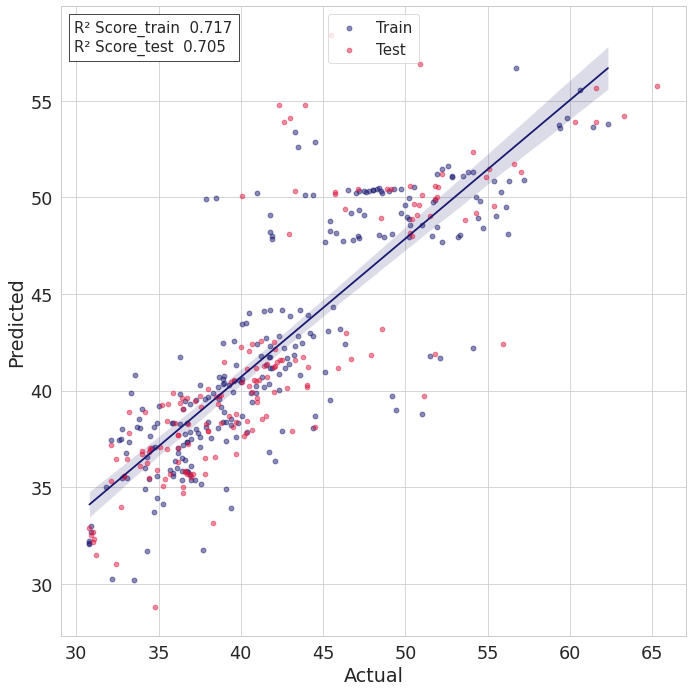

In [26]:
# Multiple Linear Regression
model = defining_model(x = 'mlr')

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'mlr')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.5576424825172404
Average validation rmse score after crossvalidation :  4.556200030906029


Training Accuracy :  0.7613868180840229
Mean absolute error (MAE):      2.854438
Mean squared error (MSE):       18.418566
Root mean squared error (RMSE): 4.291686
R square (R^2):                 0.654566


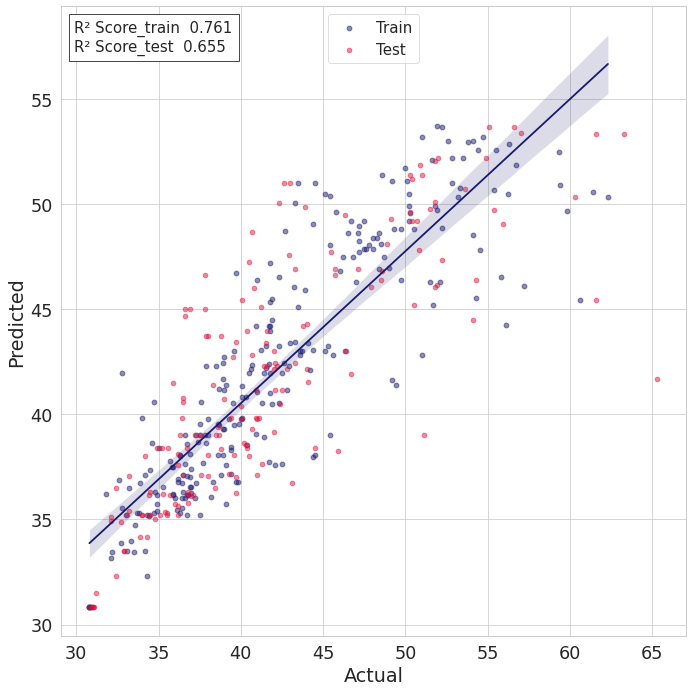

In [27]:
# KNN
model = defining_model(x = 'knn')

kfold = KFold(n_splits=5, shuffle=False)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'knn')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.6691924247434008
Average validation rmse score after crossvalidation :  3.950019655346555


Training Accuracy :  0.7696870802575866
Mean absolute error (MAE):      2.279116
Mean squared error (MSE):       13.993516
Root mean squared error (RMSE): 3.740791
R square (R^2):                 0.737556


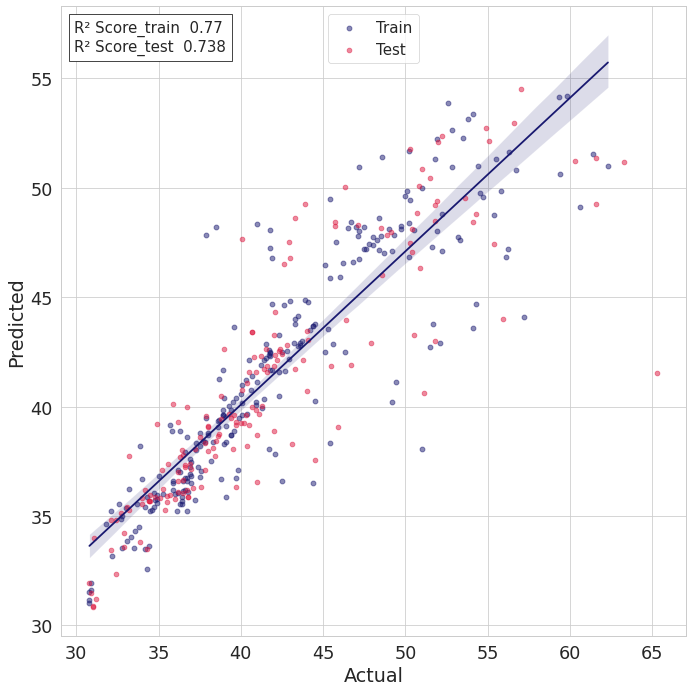

In [28]:
# Support Vector Regressor
model = defining_model(x = 'svr')

kfold = KFold(n_splits=5, shuffle=False)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'svr')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.6398796916249327
Average validation rmse score after crossvalidation :  4.127225324386905


Training Accuracy :  0.7626806642348378
Mean absolute error (MAE):      3.216752
Mean squared error (MSE):       13.850106
Root mean squared error (RMSE): 3.721573
R square (R^2):                 0.740246


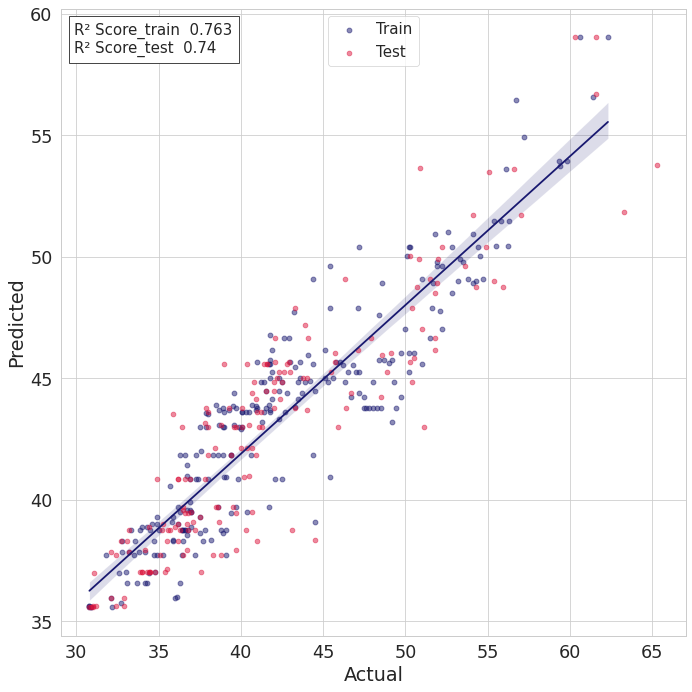

In [29]:
#Adaboost
model = defining_model(x = 'adboost')
kfold = KFold(n_splits=5, shuffle=False)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))


# Train model on whole train data
model = defining_model(x = 'adboost')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.8101248727721773
Average validation rmse score after crossvalidation :  3.0192491801488837


Training Accuracy :  1.0
Mean absolute error (MAE):      1.867420
Mean squared error (MSE):       8.388750
Root mean squared error (RMSE): 2.896334
R square (R^2):                 0.842672


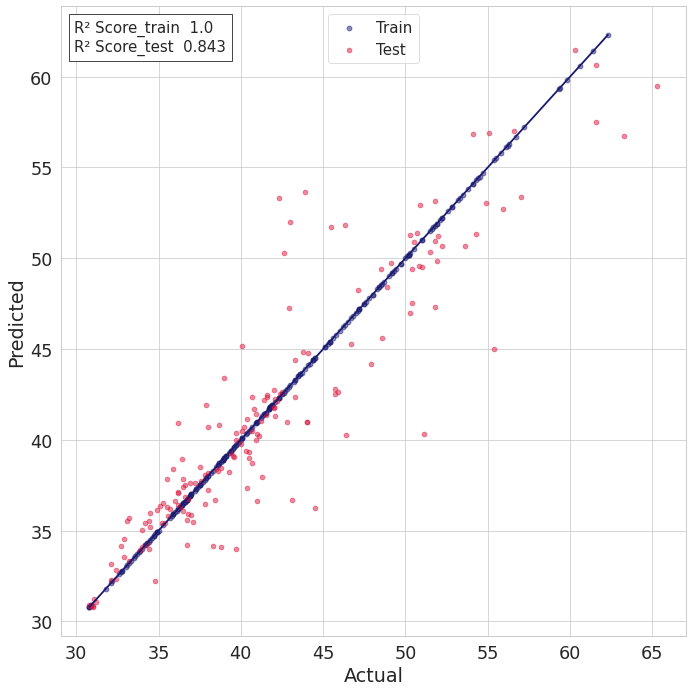

In [30]:
# Extra Tree Regressor
model = defining_model(x = 'xtratree')
kfold = KFold(n_splits=5, shuffle=True)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))


# Train model on whole train data
model = defining_model(x = 'xtratree')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.6757784312910938
Average validation rmse score after crossvalidation :  3.8548923120427268


Training Accuracy :  0.9620843561431962
Mean absolute error (MAE):      2.191834
Mean squared error (MSE):       9.902677
Root mean squared error (RMSE): 3.146852
R square (R^2):                 0.814279


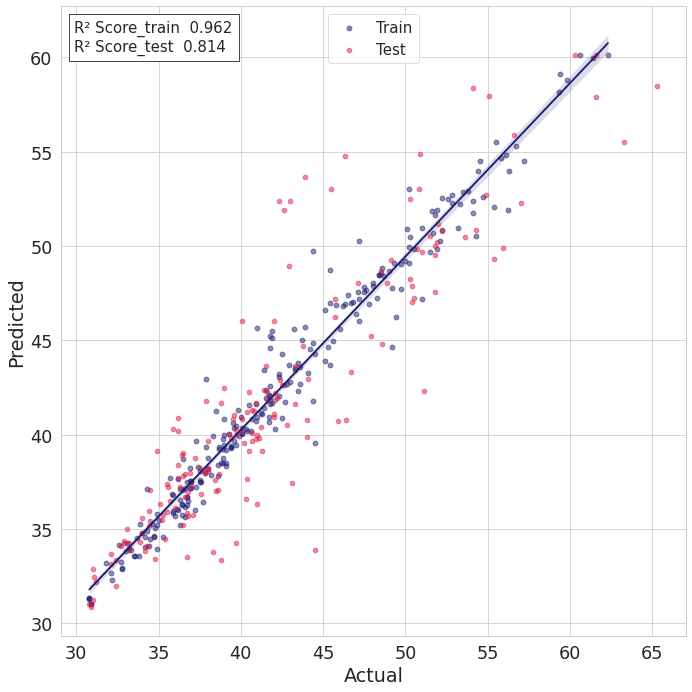

In [31]:
# Bagging Regressor
model = defining_model(x = 'bagging')
kfold = KFold(n_splits=5, shuffle=False)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'bagging')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.6966785878540248
Average validation rmse score after crossvalidation :  3.6910048263093147


Training Accuracy :  0.9652306636823561
Mean absolute error (MAE):      2.173805
Mean squared error (MSE):       9.782179
Root mean squared error (RMSE): 3.127648
R square (R^2):                 0.816538


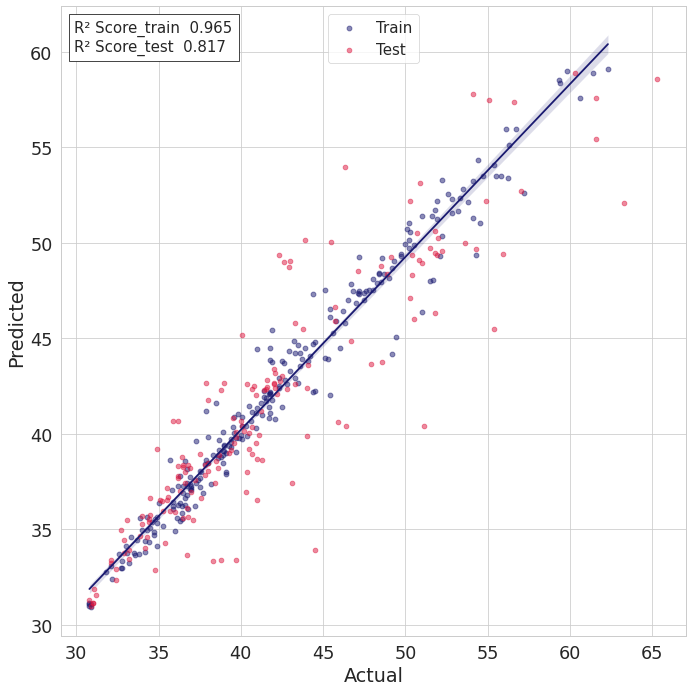

In [32]:
# Random Forest
model = defining_model(x = 'rndmfrst')
kfold = KFold(n_splits=5, shuffle=False)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))


# Train model on whole train data
model = defining_model(x = 'rndmfrst')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.6562036030598589
Average validation rmse score after crossvalidation :  4.009850596356555


Training Accuracy :  0.706137539131627
Mean absolute error (MAE):      2.808695
Mean squared error (MSE):       16.786426
Root mean squared error (RMSE): 4.097124
R square (R^2):                 0.685176


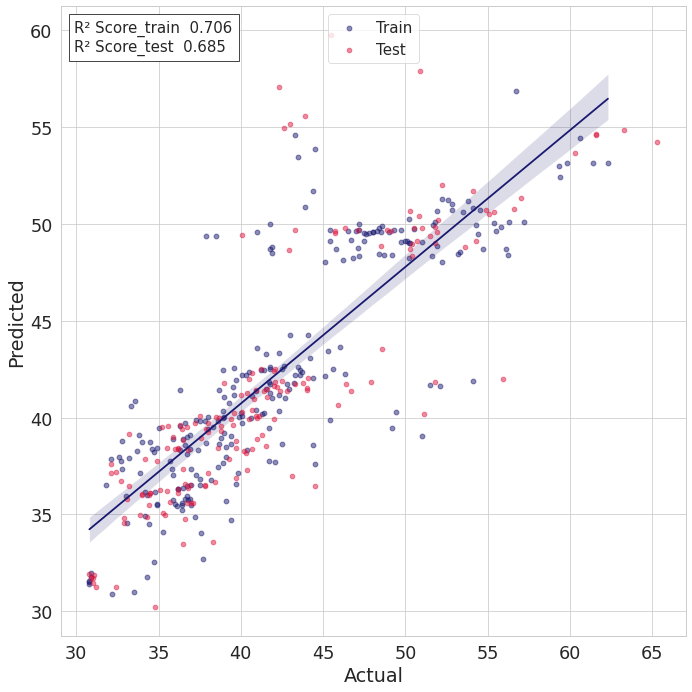

In [33]:
# Partial Least Square
model = defining_model(x = 'pls')

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'pls')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

2022-05-18 18:54:47.894883: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-18 18:54:47.895104: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-18 18:54:47.895636: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-18 18:54:47.982690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-18 18:54:48.001461: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Average validation R2 score after crossvalidation :  0.889201604621827
Average validation rmse score after crossvalidation :  2.2363449966123414


Training Accuracy :  0.9452464650067843
Mean absolute error (MAE):      1.770734
Mean squared error (MSE):       6.818609
Root mean squared error (RMSE): 2.611247
R square (R^2):                 0.872119


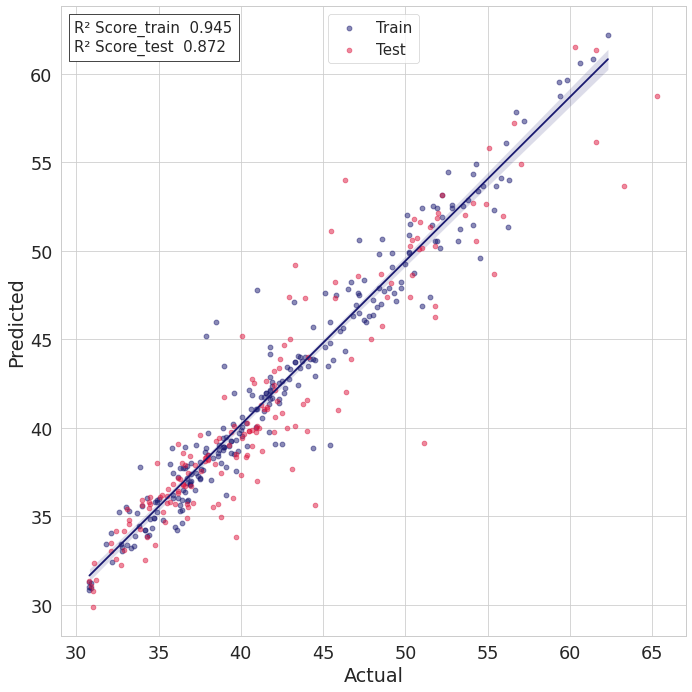

In [34]:
model = Neural_network()

kfold = KFold(n_splits=5, shuffle=True, random_state=1500)

best_score = 0.1

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  training_model(trainX.iloc[train],trainY.iloc[train],model)
  scores.append(r2_score(trainY.iloc[valid],model.predict(trainX.iloc[valid])))
  
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))
    
print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data

model = Neural_network()
training_model(trainX,trainY,model)
#actual = trainY
#predicted = model.predict(trainX)

actual=np.array(scaler.inverse_transform(np.array(trainY)))
predicted=np.array(scaler.inverse_transform(model.predict(np.array(trainX)).reshape(-1,1)))
model.save("nn.h5")
score = r2_score(actual,predicted)
print("\n\nTraining Accuracy : ",score) # Training Accuracy
plots()

In [35]:
actual_test=np.array(scaler.inverse_transform(testY).reshape(-1,1))
predicted_test=np.array(scaler.inverse_transform(model.predict(testX).reshape(-1,1)))

In [36]:
predictions_DF = Test[['Name of the Molecule','Solvent type']]
predictions_DF['Actual'] = np.squeeze(actual_test)
predictions_DF['Predicted'] = np.squeeze(predicted_test)

In [37]:
predictions_DF.to_excel('predictions.xlsx',index = False)

In [38]:
predictions_DF = Train[['Name of the Molecule','Solvent type']]
predictions_DF['Actual'] = np.squeeze(actual)
predictions_DF['Predicted'] = np.squeeze(predicted)

In [39]:
predictions_DF.to_excel('predictions_train.xlsx',index = False)